In [1]:
#Import all the files to be shared among all notebooks 
import utils
import preprocessing
import data_visualization
import feature_engineering
import ML_algorithms
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")

In [2]:
df = utils.get_dataset()

In [3]:
df = feature_engineering.drop_useless_columns(df)

In [5]:
df = preprocessing.to_dtype_object(df)

In [6]:
df = preprocessing.encode_days_as_costumer(df)

In [7]:
df = preprocessing.impute_income_KNN(df)

In [8]:
df = preprocessing.outlier_IQR(df, ["Year_Birth","Income"])

Removing outliers using the IQR method with 2 quartiles would lead to a change of data size:  -0.004910714285714286


In [9]:
# 1) obtain the observed contingency table
feature, target = "Education", "Response"
df_rec = df[[feature, target]]

obs_cont_tab = pd.crosstab(df_rec[feature], df_rec[target], margins = True)
obs_cont_tab 

Response,0,1,All
Education,,,
2n Cycle,179,22,201
Basic,52,2,54
Graduation,972,152,1124
Master,312,57,369
PhD,380,101,481
All,1895,334,2229


In [10]:
# 2) calculate the expected contingency table, assuming there is no association
exp_cont_tab = obs_cont_tab.copy()

n_r = exp_cont_tab.iloc[:-1, -1]
N = exp_cont_tab.iloc[-1, -1]
for c in range(obs_cont_tab.shape[1]-1):
    n_c = exp_cont_tab.iloc[-1, c]
    exp_cont_tab.iloc[:-1, c] = np.divide(np.multiply(n_c, n_r), N)

# visually compare both tables, side by side
pd.concat([obs_cont_tab.iloc[:, :-1], exp_cont_tab], axis=1)

Response,0,1,0,1,All
Education,,,,,
2n Cycle,179,22,170.881561,30.118439,201
Basic,52,2,45.908479,8.091521,54
Graduation,972,152,955.576492,168.423508,1124
Master,312,57,313.707941,55.292059,369
PhD,380,101,408.925527,72.074473,481
All,1895,334,1895.000000,334.000000,2229


In [11]:
# 3) compute the test statistic as measure of dissimilarity between the expected and observed tables
obs, exp = [], []
for c in range(obs_cont_tab.shape[1]-1):
    exp.append(exp_cont_tab.iloc[:-1, c].values)
    obs.append(obs_cont_tab.iloc[:-1, c].values)
    
chi_squared_stat = np.sum(np.divide(np.power(np.subtract(obs, exp), 2), exp))
print('Chi-squared test statistic: {0:.2f}'.format(chi_squared_stat))

Chi-squared test statistic: 23.57


In [12]:
from scipy import stats
chisq = stats.chi2_contingency(obs_cont_tab.iloc[:-1, [0, 1]].values)[0:2]
print("Test statistic: {0:.2f}, p-value: {1:.4f}".format(chisq[0], chisq[1]))

Test statistic: 23.57, p-value: 0.0001


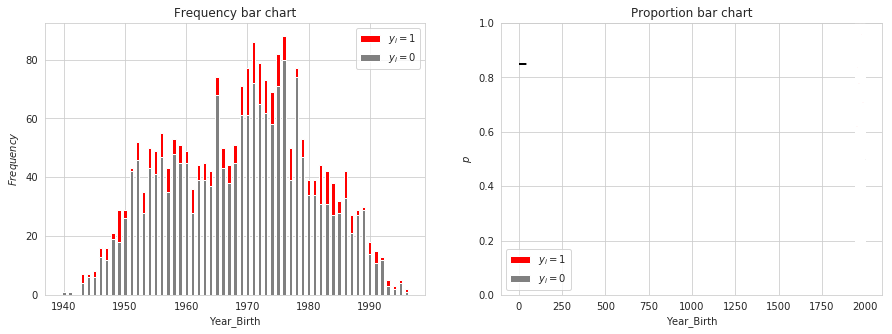

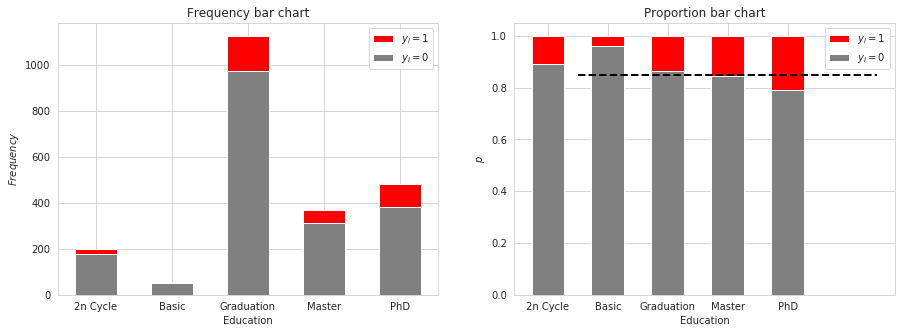

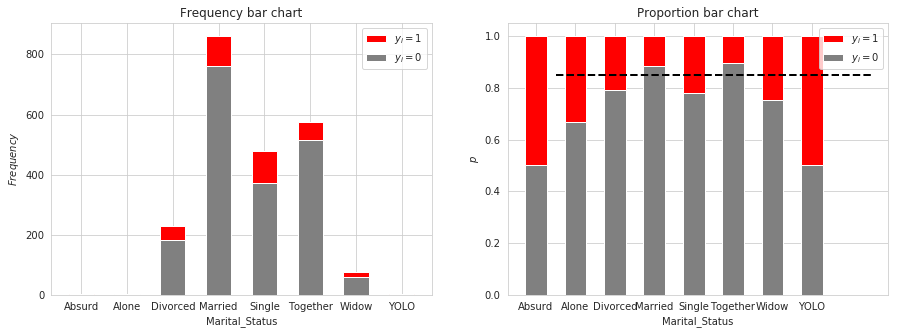

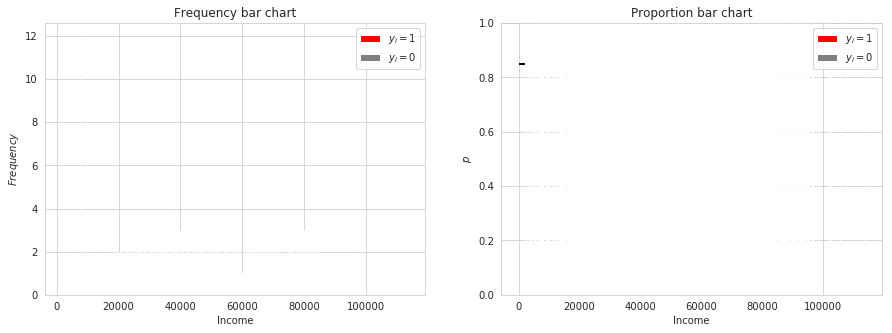

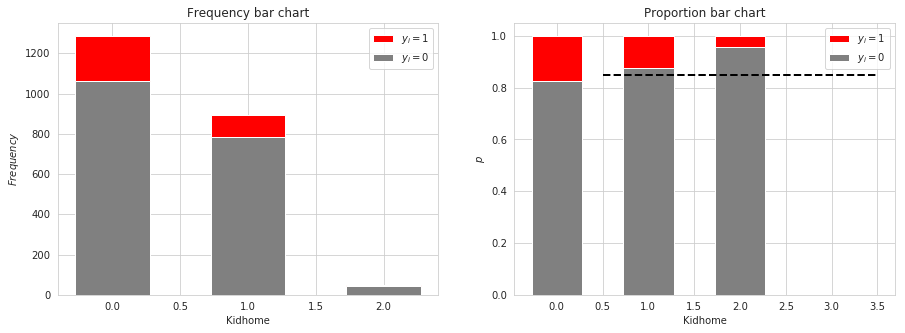

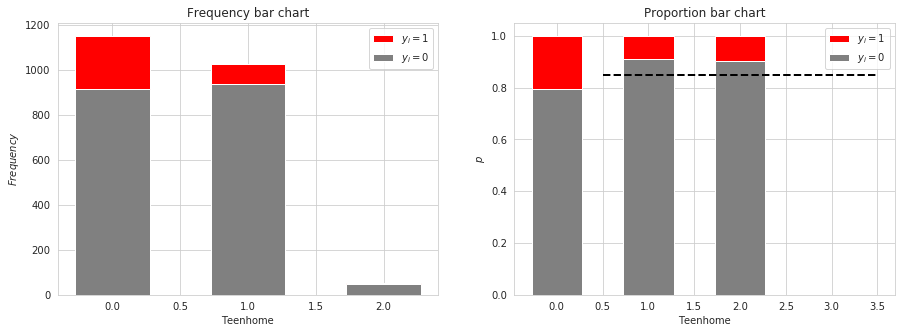

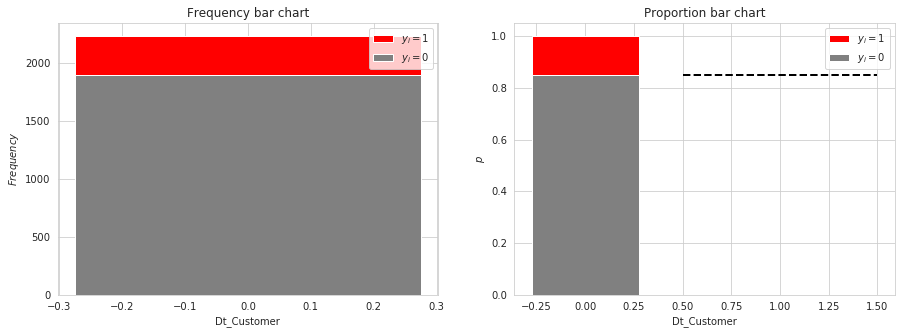

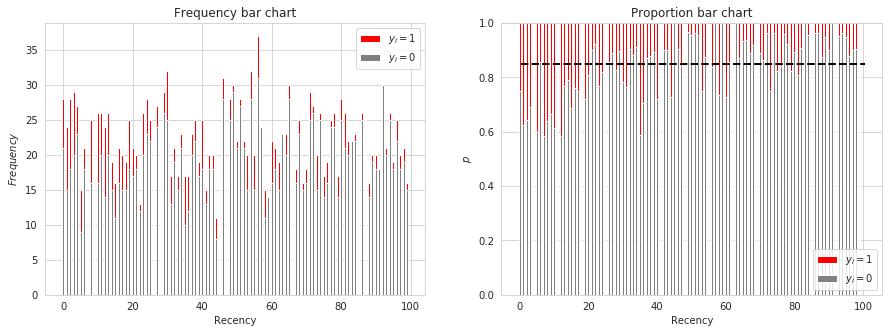

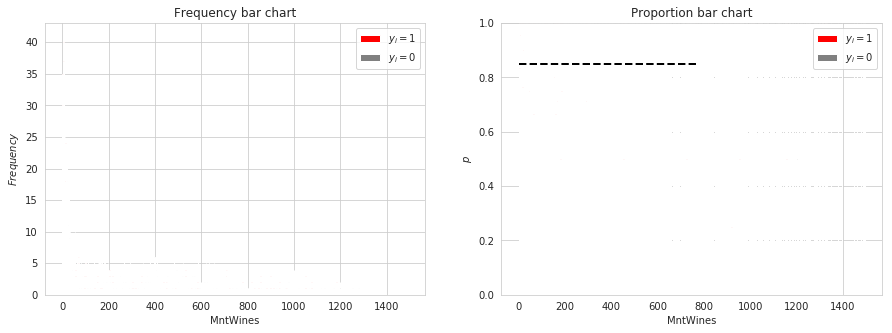

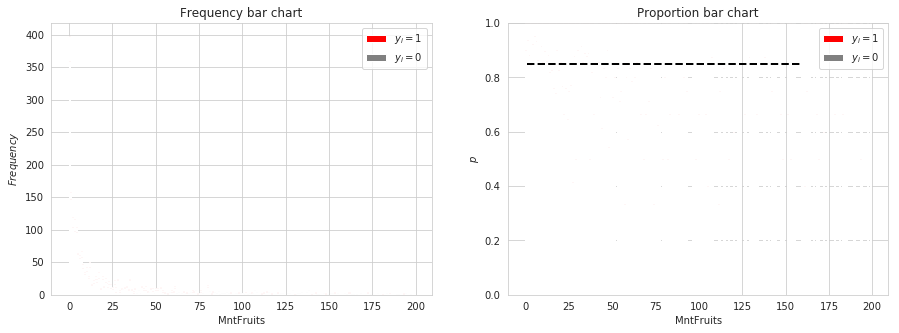

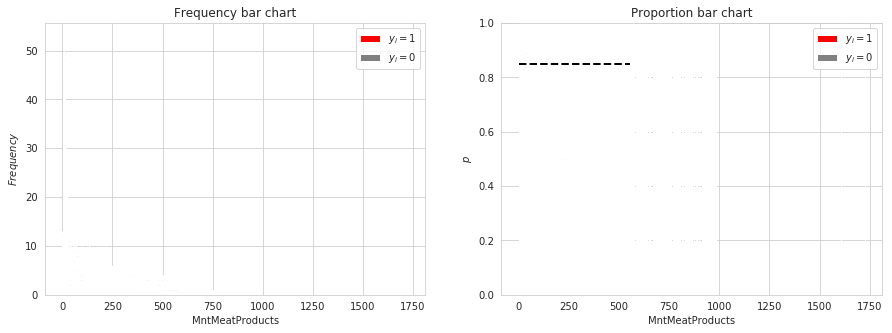

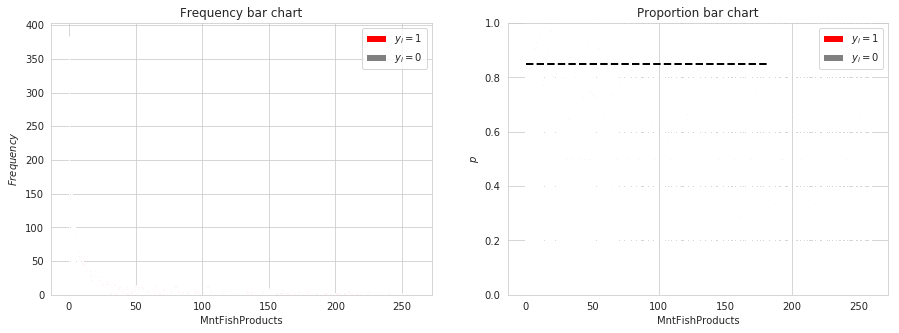

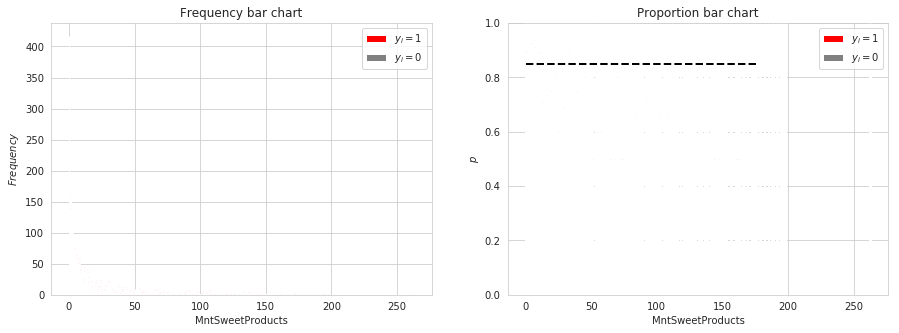

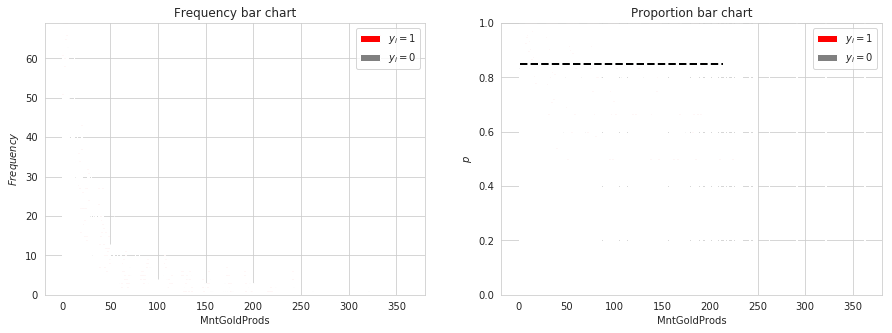

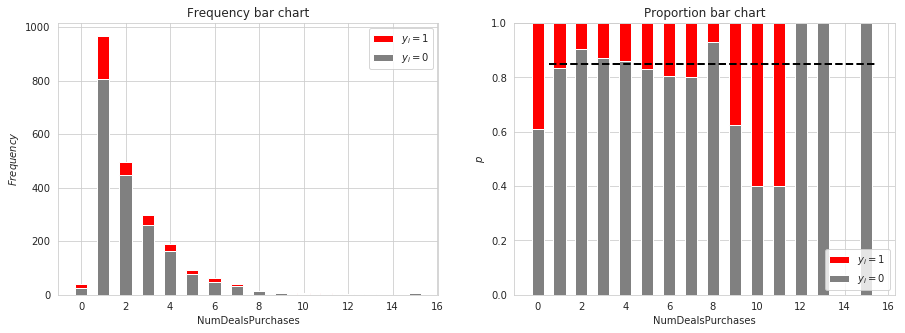

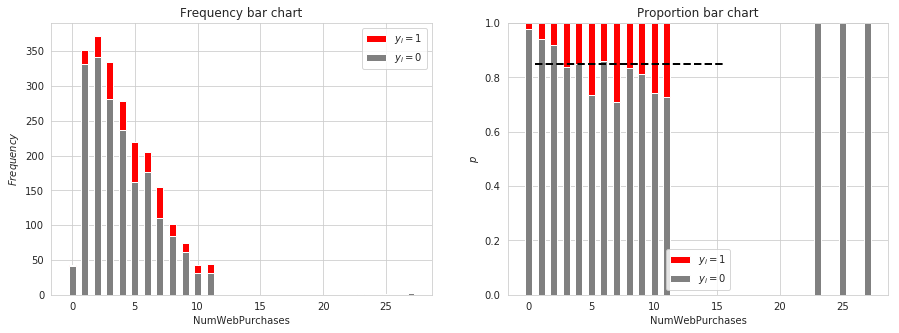

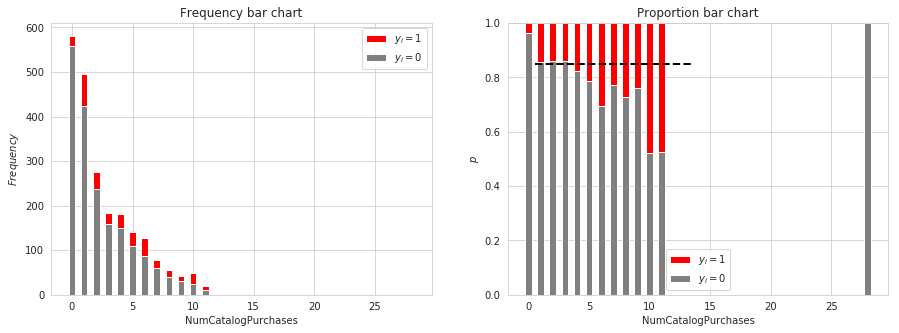

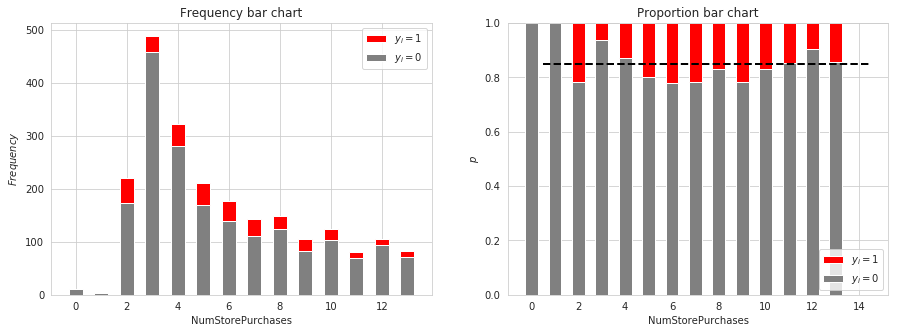

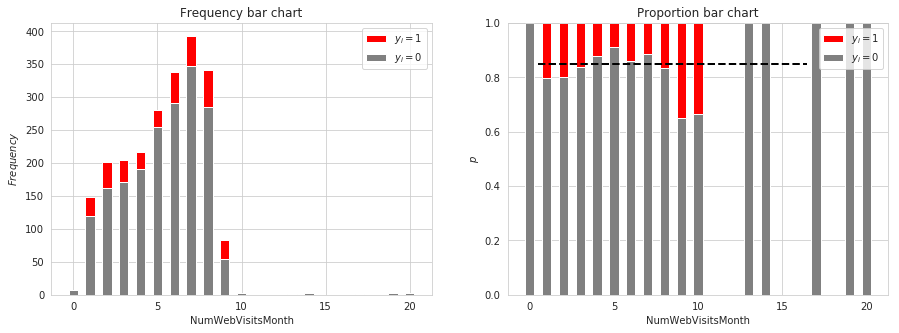

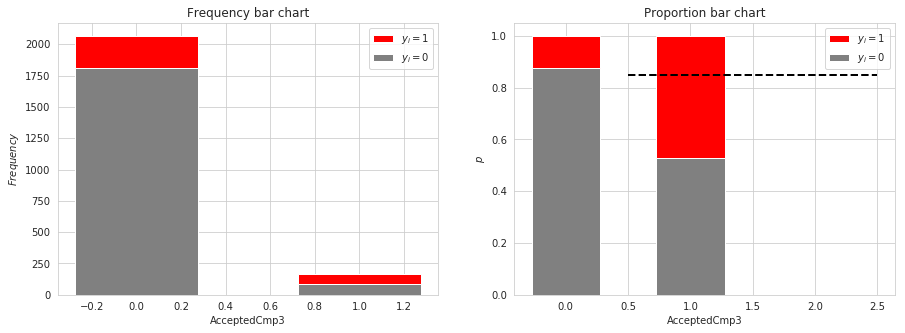

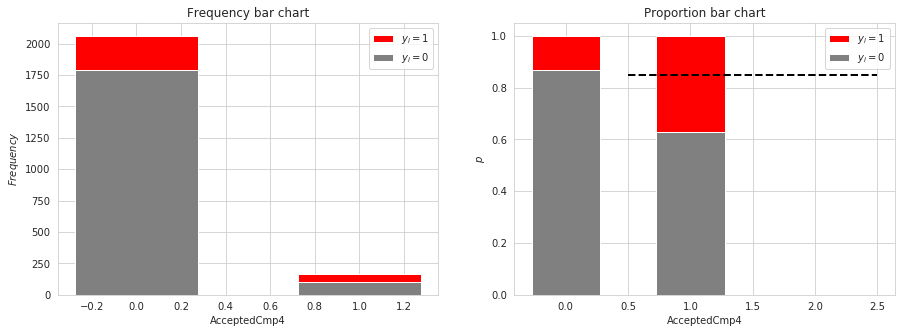

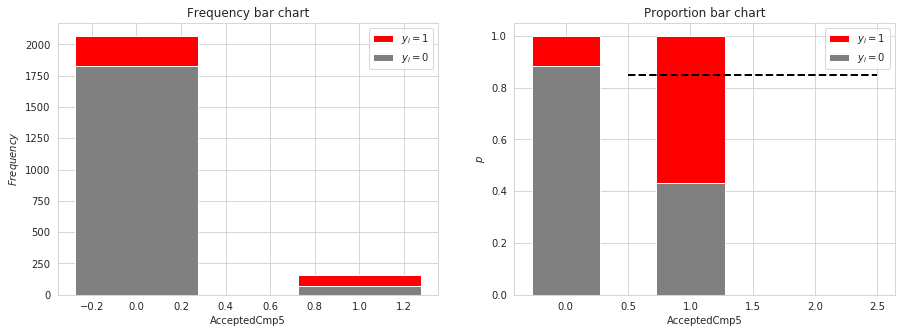

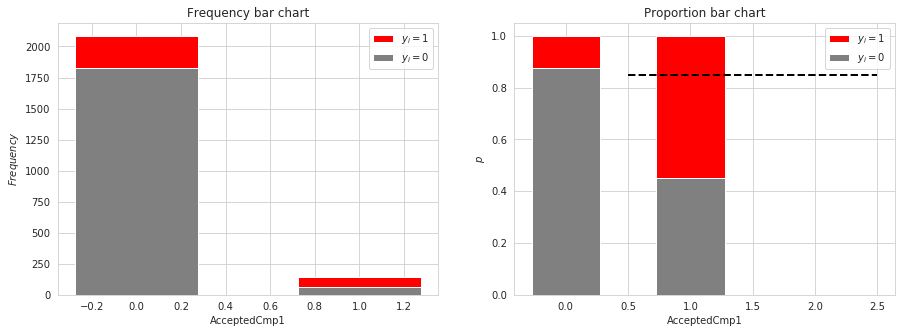

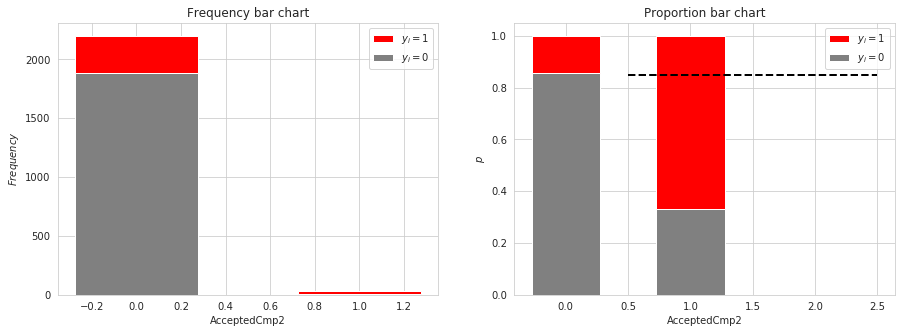

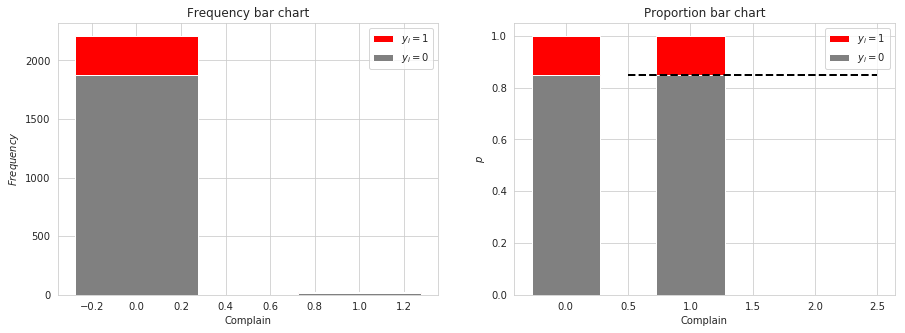

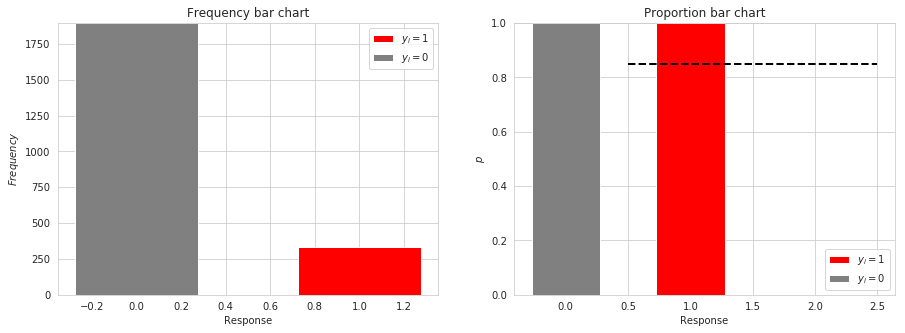

In [13]:
from sklearn.preprocessing import KBinsDiscretizer

def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 
                 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 
                 0.55, bottom=cont_tab.iloc[:-1, 0], color="red")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
    
    mean_target = 1-df[target].mean()
    
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="red")
    plt.plot([.5, len(categories)+.5], [mean_target, mean_target],'--', lw=2, color="black")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")

    plt.show()

for i in df:
    bar_charts_categorical(df, i, "Response")

In [14]:
from sklearn.preprocessing import KBinsDiscretizer

# 1) equal width binning of a continuous feature
feature, n_bins = "Income", 10
bindisc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
mnt_bin = bindisc.fit_transform(df[feature].values[:, np.newaxis])
mnt_bin = pd.Series(mnt_bin[:, 0], index=df.index)
print("Parameters of discretizer: ", bindisc.get_params())
print("Thresholds for {} bins of {}: ".format(n_bins, feature), bindisc.bin_edges_)

# 2) generate a contingency table, required for the Chi-Squared test
obs_cont_tab = pd.crosstab(mnt_bin, df[target])

# 3) compute Chi-Squared test for binned feature
chisq=stats.chi2_contingency(obs_cont_tab.values)[0:2]
print("Test statistic: {0:0.2f}, p-value: {1:0.2f}".format(chisq[0], chisq[1]))

Parameters of discretizer:  {'encode': 'ordinal', 'n_bins': 10, 'strategy': 'uniform'}
Thresholds for 10 bins of Income:  [array([  1730. ,  12930.4,  24130.8,  35331.2,  46531.6,  57732. ,
        68932.4,  80132.8,  91333.2, 102533.6, 113734. ])]
Test statistic: 156.29, p-value: 0.00


In [15]:
# 1) equal width binning of a continuous feature
feature, n_bins = "Income", 10
bindisc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
mnt_bin = bindisc.fit_transform(df[feature].values[:, np.newaxis])
mnt_bin = pd.Series(mnt_bin[:, 0], index=df.index)
print("Parameters of discretizer: ", bindisc.get_params())
print("Thresholds for {} bins of {}: ".format(n_bins, feature), bindisc.bin_edges_)

# 2) generate a contingency table, required for the Chi-Squared test
obs_cont_tab = pd.crosstab(mnt_bin, df[target])

# 3) compute Chi-Squared test for binned feature
chisq=stats.chi2_contingency(obs_cont_tab.values)[0:2]
print("Test statistic: {0:0.2f}, p-value: {1:0.2f}".format(chisq[0], chisq[1]))

Parameters of discretizer:  {'encode': 'ordinal', 'n_bins': 10, 'strategy': 'quantile'}
Thresholds for 10 bins of Income:  [array([  1730. ,  24016.8,  31870.4,  38004.2,  44375.4,  51141. ,
        58115.4,  65003. ,  71474.8,  79593. , 113734. ])]
Test statistic: 139.61, p-value: 0.00


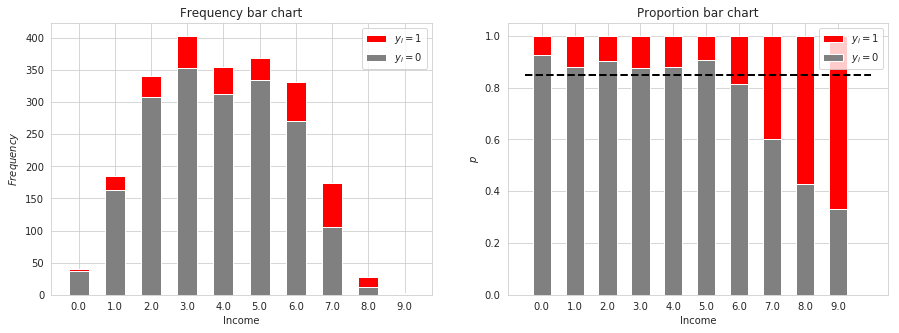

Test statistic: 156.29, p-value: 0.00


In [18]:
from sklearn.preprocessing import KBinsDiscretizer

def bar_charts_continuous(df, feature, target, n_bins=10, binning_strategy="uniform", chi_sq=False):
    bindisc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', 
                               strategy=binning_strategy)
    feature_bin = bindisc.fit_transform(df[feature].values[:, np.newaxis])
    feature_bin = pd.Series(feature_bin[:, 0], index=df.index)
    
    cont_tab = pd.crosstab(feature_bin, df[target], margins = True)
    categories = cont_tab.index[:-1].astype(str) 
    
    if chi_sq:
        chisq = stats.chi2_contingency(cont_tab.values)[0:2]       
    
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 
                 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 
                 0.55, bottom=cont_tab.iloc[:-1, 0], color="red")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
    
    mean_target = 1-df[target].mean()
    
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="red")
    plt.plot([-.5, len(categories)], [mean_target, mean_target],'--', lw=2, color="black")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    plt.show()
    
    if chi_sq:
        return chisq

chi_sq=bar_charts_continuous(df, "Income", "Response", 10, "uniform", True)
print("Test statistic: {0:0.2f}, p-value: {1:0.2f}".format(chi_sq[0], chi_sq[1]))

In [19]:
feature, target = "Income", "Response"
df_smd = df[[feature, target]]

mean_feature = df_smd[feature].mean()
df_smd[feature+"_SMD"] = (df_smd[feature].sub(mean_feature)).div(mean_feature)

smd_summary = df_smd.groupby([target]).agg({feature+"_SMD": "mean", feature: "mean"})  
display(smd_summary)
print("Average {0}: {1:.2f}, SMD of {2}: {3:.2f}".format(feature, mean_feature, feature, smd_summary[feature+"_SMD"].abs().sum()))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Income_SMD,Income
Response,,
0,-0.029844,49962.791557
1,0.169327,60220.077844


Average Income: 51499.77, SMD of Income: 0.20


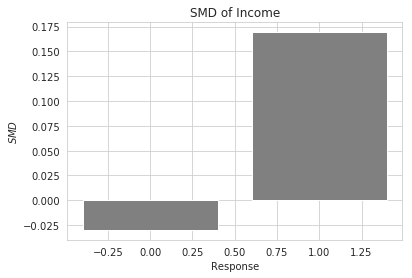

In [20]:
# plots the bar chart
plt.bar(x = smd_summary.index, height=smd_summary[feature+"_SMD"], color="gray")
plt.title("SMD of " + feature)
plt.xlabel(target)
plt.ylabel("$SMD$")
plt.show()

In [22]:
# 1) intermediary step: compute SMD0, SMD1 and SMD for every continuous feature
num_list = df.select_dtypes(include=["number"]).drop(["Response"], axis=1).columns
target = "Response"

smd_dict = {"smd0": [], "smd1": [], "smd": []}
for feature in num_list:
    df_smd = df[[feature, target]]
    mean_feature = df_smd[feature].mean()
    df_smd[feature] = (df_smd[feature].sub(mean_feature)).div(mean_feature) 
    smd_summary = df_smd.groupby([target]).agg({feature: "mean"})  
    smd_dict["smd0"].append(smd_summary.iloc[0, 0])
    smd_dict["smd1"].append(smd_summary.iloc[1, 0])
    smd_dict["smd"].append(smd_summary[feature].abs().sum())

smd_dict

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


{'smd0': [-4.7214948729166604e-05,
  -0.029844448175677635,
  0.040942626115249244,
  0.07017209885010699,
  nan,
  0.04925516665444523,
  -0.1142570052478197,
  -0.07930155506643591,
  -0.1376351838283498,
  -0.06746475903533972,
  -0.07445070659345579,
  -0.0692540490725242,
  -0.0011741960568607092,
  -0.04177636450931714,
  -0.10475055255427487,
  -0.008591693745667319,
  0.0013486866194291488],
 'smd1': [0.0002678812210833298,
  0.16932703381110545,
  -0.2322942409832198,
  -0.398132117727411,
  nan,
  -0.27945670901249625,
  0.6482545657024498,
  0.4499294815895107,
  0.7808942316009638,
  0.38277161189212056,
  0.42240745207963754,
  0.3929234221330344,
  0.006661980622008709,
  0.23702458306933627,
  0.5943182547615345,
  0.04874628637137576,
  -0.007651979472509952],
 'smd': [0.0003150961698124964,
  0.19917148198678308,
  0.27323686709846906,
  0.468304216577518,
  0.0,
  0.3287118756669415,
  0.7625115709502694,
  0.5292310366559466,
  0.9185294154293137,
  0.450236370927460

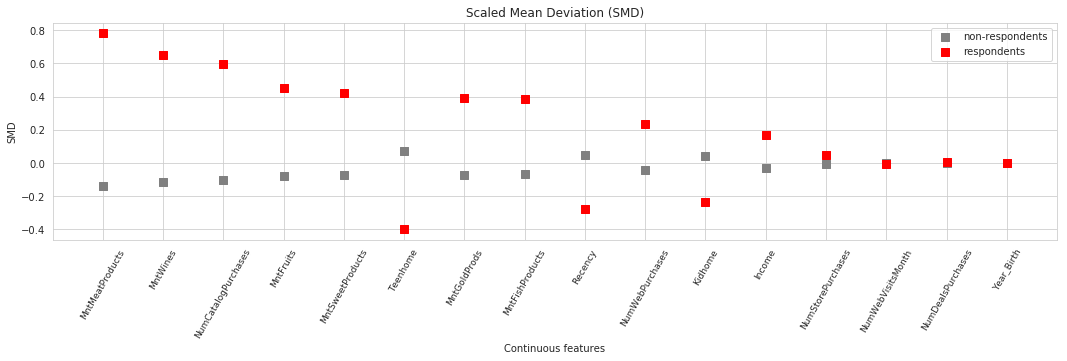

In [25]:
# 2) intermediary step: plot SMD0 (gray), SMD1 (red) ordered by SMD
import operator
import matplotlib
import matplotlib.pyplot as plt

df1 = pd.DataFrame(smd_dict, index=num_list).sort_values("smd", ascending=False)
colors, groups = ("gray", "red"), ("non-respondents", "respondents")
g0, g1 = (df1.index, df1.iloc[:, 0]), (df1.index, df1.iloc[:, 1])
data = (g0, g1)

fig = plt.figure(figsize=(len(df1.index)+1, 4))
ax = fig.add_subplot(1, 1, 1, facecolor = "1.0")
for data, color, group in zip(data, colors, groups):    
    X, y = data
    ax.scatter(x=X, y=y.values, s=80, marker="s", label=group, c=color)

ax.set_title("Scaled Mean Deviation (SMD)")
ax.set_xlabel("Continuous features")
ax.set_ylabel("SMD")
ax.legend()
plt.xticks(fontsize=9, rotation=60)  

plt.show()

In [28]:
def smd01_plot(df, nfeature_list, target, return_df_smd=True):  
    smd_dict = {"smd0": [], "smd1": [], "smd": []}
    for feature in num_list:
        df_smd = df[[feature, target]]
        mean_feature = df_smd[feature].mean()
        df_smd[feature] = (df_smd[feature].sub(mean_feature)).div(mean_feature) 
        df_smd = df_smd.groupby([target]).agg({feature: "mean"})  
        smd_dict["smd0"].append(df_smd.iloc[0, 0])
        smd_dict["smd1"].append(df_smd.iloc[1, 0])
        smd_dict["smd"].append(df_smd[feature].abs().sum())

    df_smd = pd.DataFrame(smd_dict, index=num_list).sort_values("smd", ascending=False)
    colors, groups = ("gray", "red"), ("non-respondents", "respondents")
    g0, g1 = (df_smd.index, df_smd.iloc[:, 0]), (df_smd.index, df_smd.iloc[:, 1])
    data = (g0, g1)

    fig = plt.figure(figsize=(len(df_smd.index)+1, 4))
    ax = fig.add_subplot(1, 1, 1, facecolor = "1.0")
    for data, color, group in zip(data, colors, groups):    
        X, y = data
        ax.scatter(x=X, y=y.values, s=80, marker="s", label=group, c=color)

    ax.set_title("Scaled Mean Deviation (SMD)")
    ax.set_xlabel("Continuous features")
    ax.set_ylabel("SMD")
    ax.legend()
    plt.xticks(fontsize=9, rotation=60)    
    plt.show()
    
    if return_df_smd:
        return df_smd

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


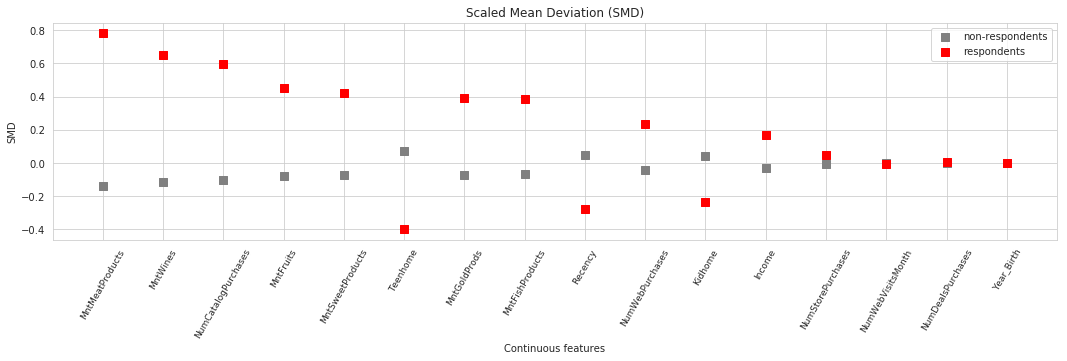

In [29]:
df_smd = smd01_plot(df, num_list, target)

In [50]:
from sklearn.preprocessing import KBinsDiscretizer

def chisq_ranker(df, target,continuous_flist = list(df.select_dtypes(include=["number"]).drop(["Response"], axis=1).columns),categorical_flist = list(df.select_dtypes(include=["object"]).columns), n_bins=10, binning_strategy="uniform"):
    """
    Input the dataframe and the target, you can also choose the continuous variables you want to include from the dataframe but a default has been set.
    The same goes for the categorical variables.
    The output that will be given is the ranking of the features using the Chi-Squared test
    """
    chisq_dict = {}
    if  continuous_flist:
        bindisc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', 
                               strategy=binning_strategy)
        for feature in continuous_flist:            
            feature_bin = bindisc.fit_transform(df[feature].values[:, np.newaxis])
            feature_bin = pd.Series(feature_bin[:, 0], index=df.index)
            cont_tab = pd.crosstab(feature_bin, df[target], margins = False)
            chisq_dict[feature] = stats.chi2_contingency(cont_tab.values)[0:2] 
    if  categorical_flist:
        for feature in categorical_flist:  
            cont_tab = pd.crosstab(df[feature], df[target], margins = False)          
            chisq_dict[feature] = stats.chi2_contingency(cont_tab.values)[0:2]
            
    df_chisq_rank = pd.DataFrame(chisq_rank, index=["Chi-Squared", "p-value"]).transpose()
    df_chisq_rank.sort_values("Chi-Squared", ascending=False, inplace=True)
    df_chisq_rank["valid"]=df_chisq_rank["p-value"]<=0.05
    df_chisq_rank
    return df_chisq_rank

In [52]:
df_chisq_rank = chisq_ranker(df, target)
df_chisq_rank.head()

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:161: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


,Chi-Squared,p-value,valid
AcceptedCmp5,236.149106,2.718942e-53,True
AcceptedCmp1,188.832003,5.718521e-43,True
MntWines,168.199129,1.463491e-31,True
Income,156.292337,4.372377e-29,True
AcceptedCmp3,140.904569,1.688145e-32,True


In [53]:
def chisq_ranker_plot(df_chisq_rank):
    """
    The Chi-Square ranker plot takes the output of the Chi-Squared ranker function and creates a plot out of the inputted dataframe.
    """
    colors = {True: 'gray', False: 'lightgray'}
    fig, ax = plt.subplots(figsize=(7,5))
    df_chisq_rank['Chi-Squared'].plot(ax=ax, kind='bar', color=[colors[i] for i in df_chisq_rank['valid']])
    ax.set_title("Features worth by Chi-Squared test statistic")
    ax.set_xlabel("Input features")
    ax.set_ylabel("Test statistic")
    ax.set_xticklabels(df_chisq_rank.index, rotation=70)
    ax.legend(["p-value<=0.5"])
    plt.show()

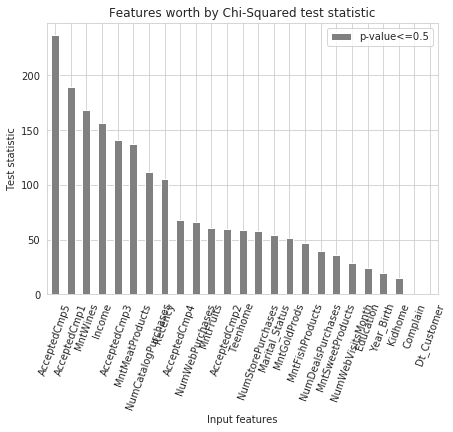

In [54]:
chisq_ranker_plot(df_chisq_rank)

In [ ]:
def impute_income_KNN(df):
    dataframe = df.copy()
    dataframe_c = dataframe.dropna().select_dtypes(include=["number"]).drop(["Response"], axis = 1)
    dataframe_i = dataframe[pd.isnull(dataframe).any(axis=1)].select_dtypes(include=["number"]).drop(["Response"], axis = 1)
    clf = KNeighborsClassifier(3, weights='uniform', metric = 'euclidean')
    trained_model = clf.fit(dataframe_c.drop(["Income"],axis=1), dataframe_c.loc[:,'Income'])
    imputed_values = trained_model.predict(dataframe_i.drop(["Income"], axis=1))
    #print(imputed_values)
    dataframe_i["Income"] = imputed_values
    dataframe_new = pd.concat([df_i, df_c])
    dataframe_new = dataframe_new.sort_index()
    dataframe["Income"] = dataframe_new["Income"]
    return dataframe

In [ ]:
def outlier_IQR(df, columns=["Year_Birth","Income"]):
    """
    outlier deletetion using the IQR, you can choose the variables you want to delete the outliers for by selecting the columns. The default is Year_Birth & Income. Also you can change the quantile values.
    """
    dataframe = df.copy()
    Q1 = dataframe[columns].quantile(0.25)
    Q3 = dataframe[columns].quantile(0.75)
    IQR = Q3 - Q1
    #print(IQR)
    dataframe[columns] = dataframe[columns][~((dataframe < (Q1 - 2 * IQR)) |(dataframe > (Q3 + 2 * IQR))).any(axis=1)]
    dataframe = dataframe.dropna()
    print('Removing outliers using the IQR method with 2 quartiles would lead to a change of data size: ',(dataframe.shape[0] -df.shape[0]) /df.shape[0])
    return dataframe

In [ ]:
def outlier_ZSCORE(df, columns=["Year_Birth", "Income"], threshold=3):
    """
    outlier deletion using the Zscore, you can choose which columns you want to apply it on and you can choose which threshold you want to use.
    """
    dataframe = df.copy()
    columns_zscore = []
    for i in dataframe[columns]:
        i_zscore = i + "_zscore"
        columns_zscore.append(str(i_zscore))
        
        dataframe[i_zscore] = (dataframe[i] - dataframe[i].mean())/df[i].std(ddof=0)
    for i in dataframe[columns_zscore]:
        dataframe = dataframe[(dataframe[i] < threshold) & (dataframe[i] > -threshold)]
    dataframe = dataframe.drop(columns_zscore, axis=1)
    print('Removing outliers using the ZSCORES method with a threshold of 3 would lead to a change of data size: ',(dataframe.shape[0] -df.shape[0]) /df.shape[0])
    return dataframe

In [ ]:
outlier_IQR(df,["Year_Birth","Income","MntSweetProducts","MntMeatProducts","MntGoldProds"]).head()

outlier_ZSCORE(df,["Year_Birth","Income","MntSweetProducts","MntMeatProducts","MntGoldProds"]).head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def Min_Max_Train(X_train, X_test):    
    scaler = MinMaxScaler()
    # Only fit the training data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [ ]:
def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

from keras import models
from keras import layers

def KerasNN1(X_train, X_test, y_train, y_test, n_layers=4, optimizer="rmsprop", loss="binary_crossentropy", init="uniform", metrics=["accuracy"]):
    """
    Keras Neural Network, define the amount of layers you want, which optimizer you want to use and which loss function you want to apply.
    """ 
    np.random.seed(42)

    model = models.Sequential()
    model.add(layers.Dense(6, activation="relu", input_dim=len(df.columns) -1))
    for num in range(n_layers-2):
        model.add(layers.Dense(6, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid", init=init))
    model.compile(optimizer, loss, metrics=metrics)
    
    initial_weights = model.get_weights()
    
    shuffle_weights(model, initial_weights)
    
    model.fit(X_train, y_train, epochs=100, verbose=0)
    return model

In [ ]:
def NN_evaluation(model):
    y_predicted = model.predict(X_test)
    threshold = utils.max_threshold(y_predicted, y_test, threshold_range = (0.1, 0.99),iterations=10000, visualization=True)
    y_pred = utils.predict_with_threshold(y_predicted,threshold)

    print("Accuracy {:1.2f}".format(utils.calculate_accuracy(y_pred, y_test)))
    print("Area under the curve {:1.2f}".format(utils.calculate_auc(y_pred, y_test)))
    print("Precision {:1.2f}".format(utils.calculate_precision_score(y_pred, y_test)))
    print("Recall {:1.2f}".format(utils.calculate_recall_score(y_pred, y_test)))
    print("Profit Share {:1.2f}".format(utils.profit_share(y_pred, y_test)))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

from keras import models
from keras import layers

def KerasNN(X_train, X_test, y_train, y_test, optimizer="rmsprop", loss="binary_crossentropy"):
    """
    Try to variate in optimizers & loss functions
    """
    scaler = MinMaxScaler()
    # Only fit the training data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # if we can pass a variable that indicates the amount of layers than it would be cool
    model = models.Sequential()
    model.add(layers.Dense(6, activation="relu", input_dim=30))
    model.add(layers.Dense(6, activation="relu"))
    model.add(layers.Dense(6, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile(optimizer, loss, metrics=["accuracy"])
    
    model.fit(X_train, y_train, epochs=100, verbose=0)
    y_predicted = model.predict(X_test)
    threshold = utils.max_threshold(y_predicted, y_test, threshold_range = (0.1, 0.99),iterations=10000, visualization=True)
    y_pred = utils.predict_with_threshold(y_predicted,threshold)
    
    print("Accuracy {:1.2f}".format(utils.calculate_accuracy(y_pred, y_test)))
    print("Area under the curve {:1.2f}".format(utils.calculate_auc(y_pred, y_test)))
    print("Precision {:1.2f}".format(utils.calculate_precision_score(y_pred, y_test)))
    print("Recall {:1.2f}".format(utils.calculate_recall_score(y_pred, y_test)))
    print("Profit Share {:1.2f}".format(utils.profit_share(y_pred, y_test)))
    return utils.profit_share(y_pred, y_test)